# Part 0: Find and clean appropriate datasets [don't need to rerun]

Your text assignments this block will use two different sources. One is a list of names, as we had back in block 1.
The other will be a bunch of text all from a similar source, likely the collection of books all the same author.
You will find one other person in class to share the same names data, and a different classmate to share the same books data.

You might need to do some preprocessing, which you can do here. We should now have a list of strings in the variable `names` and a big giant string in the variable `books`.

# Part 1: Create x, y data [Rerun this to whole part to reimport data]

In [1]:
#@title Import libraries and text data
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import requests
import random
import math
from collections import defaultdict

## If running on colab / google drive, will need to mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# with open("NAMES FILE HERE", "r") as f:
#     names = [line.strip() for line in f]
url = "http://www.aayanarish.com/ml_datasets/british_roads.txt"
names = requests.get(url).text.splitlines()
names = [i + "$" for i in names]
random.shuffle(names)

url = "http://www.aayanarish.com/ml_datasets/trump_speeches.txt"
books_in = requests.get(url).text
books_in = books_in.replace("â", "").replace("", " ").replace("", " ").replace("", " ").replace("", " ").replace("¦", "")

In [2]:
if torch.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:
# Example list of strings
string_list = books_in.split()

# Dictionary to store character counts and first 3 words they appear in
char_data = defaultdict(lambda: {"count": 0, "words": set()})

# Process each word
for word in string_list:
    for char in set(word): # Use set() to avoid duplicate counting in the same word
        char_data[char]["count"] += word.count(char)
        if len(char_data[char]["words"]) < 10:
            char_data[char]["words"].add(word)

# Convert dictionary to sorted list by frequency (descending)
sorted_char_data = sorted(char_data.items(), key=lambda x: x[1]["count"], reverse=True)

chars = []

# Print results
for char, data in sorted_char_data:
    print(f"'{char}': {data['count']} | First 10 words: {', '.join(data['words'])}")
    if data['count'] > 1000:
        chars.append(char)

chars = sorted(chars)

'e': 1650784 | First 10 words: very, are, white, house, welcome, minister, please., prime, the, honored
't': 1314236 | First 10 words: to, united, netanyahu, emirates,, netanyahu., thank, first, minister, white, the
'a': 1089619 | First 10 words: abdullah, sara., netanyahu, are, netanyahu., thank, please., israel,, and, lady
'o': 1084207 | First 10 words: so, to, of, you,, you, house, welcome, you., honored, foreign
'i': 931316 | First 10 words: israel,, united, bin, emirates,, i, first, minister, white, prime, foreign
'n': 923059 | First 10 words: zayani, united, netanyahu, bin, netanyahu., thank, minister, and, honored, foreign
'r': 731777 | First 10 words: very, israel,, sara., are, first, minister, mrs., prime, honored, foreign
's': 727641 | First 10 words: so, sara., emirates,, this, first, minister, house, mrs., please., israel,
'h': 720526 | First 10 words: abdullah, netanyahu, bahrain., netanyahu., thank, much., house, white, the, honored
'l': 536091 | First 10 words: abdullah,

In [4]:
#@title Process characters in each dataset
vocab_books1 = sorted(list(set(books_in)))
books = books_in
for x in vocab_books1:
    if books.count(x) < 1000:
        books = books.replace(x, "")
vocab_books = sorted(list(set(books)))
vocab_names = sorted(list(set(''.join(names)))) # names has the special start / end token

stoi_books = {s:i for i,s in enumerate(vocab_books)}
itos_books = {i:s for s,i in stoi_books.items()}

stoi_names = {s:i for i,s in enumerate(vocab_names)}
itos_names = {i:s for s,i in stoi_names.items()}

print(f"names uses {len(vocab_names)} characters: {''.join(vocab_names)}")
print(f"books uses {len(vocab_books)} characters: {''.join(vocab_books)}")


names uses 28 characters: $_abcdefghijklmnopqrstuvwxyz
books uses 43 characters:  $%,-.0123456789?abcdefghijklmnopqrstuvwxyz


In [5]:
#@title Split into training and validation set

def train_val_split(data, val_fraction = 0.1):
    random.seed(123)
    random.shuffle(data)
    val_count = int(val_fraction * len(data))
    val = data[:val_count]
    train = data[val_count:]
    return train, val

train_names, val_names = train_val_split(names)

## We are splitting books into 1000 even chunks, of which 10% will become validation
## This is lazily just splitting characters evenly, since the gaps will be neglible.
## Feel free to make the split be more intelligently between words or sentences.
num_book_chunks = 1000
chunk_size = math.ceil(len(books) / num_book_chunks)
book_chunks = [books[i:i + chunk_size] for i in range(0, len(books), chunk_size)]
train_books, val_books = train_val_split(book_chunks)

In [7]:
#@title Process datasets into x, y to train models
def make_x_y(words, stoi, context_size, start_token = ''):
    """
    Generates input (x) and target (y) data for a language model.

    This function takes a list of words, a string-to-index mapping (stoi),
    and a context size to create context-target pairs for training.
    It pads each word with start tokens and then uses a sliding window
    to generate the context (x) and the target (y) for each position
    in the padded word.

    Args:
        words (list): A list of strings, where each string represents a word or a chunk of text.
        stoi (dict): A dictionary mapping characters to their numerical indices.
        context_size (int): The size of the context window (number of preceding characters
                            to consider for prediction).
        start_token (str, optional): Defaults to '' for books, and should be '$' for names.

    Returns:
        tuple: A tuple containing two PyTorch tensors:
            - x (torch.Tensor): A tensor of shape (num_examples, context_size) representing
                                the input context for each example.
            - y (torch.Tensor): A tensor of shape (num_examples,) representing the target
                                token (to be predicted) for each example.
    """
    x = []
    y = []
    for w in words:
        if start_token:
            w = f"{start_token}"*(context_size) + w
        for i in range(len(w) - context_size):
            x_tmp = w[i:i+context_size]
            y_tmp = w[i+context_size]
            x.append(list(map(lambda a: stoi[a], x_tmp)))
            y.append(stoi[y_tmp])
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

# the preprocessing to create all the x,y datasets might be a bit slow
# my naive implementation took about 2 minutes to run this cell
# (my books dataset of all HP books is 6.5 million characters,
#  my names dataset of species names is 100k names with a total of
#  1.9 million characters)
# you could pickle / unpickle these variables if your preprocessing is slow
# and you don't want to rerun this cell often

## our x, y datasets will all be dictionaries taking context size as a key
x_train_books, y_train_books, x_val_books, y_val_books = {}, {}, {}, {}
x_train_names, y_train_names, x_val_names, y_val_names = {}, {}, {}, {}
for context_size in [1,2,3,4,6,8,10,12,16]:
    x_train_books[context_size], y_train_books[context_size] = make_x_y(train_books, stoi_books, context_size)
    x_val_books[context_size], y_val_books[context_size] = make_x_y(val_books, stoi_books, context_size)
    x_train_names[context_size], y_train_names[context_size] = make_x_y(train_names, stoi_names, context_size, start_token = '$')
    x_val_names[context_size], y_val_names[context_size] = make_x_y(val_names, stoi_names, context_size, start_token = '$')


Here are some examples of what x and y looked like from my datasets:

In [8]:
print(train_names[0][:20])
print(' '.join([f'{c}:{stoi_names[c]}' for c in train_names[0]][:20]))
print(x_train_names[3][:7])
print(y_train_names[3][:7])

old_riding$
o:16 l:13 d:5 _:1 r:19 i:10 d:5 i:10 n:15 g:8 $:0
tensor([[ 0,  0,  0],
        [ 0,  0, 16],
        [ 0, 16, 13],
        [16, 13,  5],
        [13,  5,  1],
        [ 5,  1, 19],
        [ 1, 19, 10]])
tensor([16, 13,  5,  1, 19, 10,  5])


In [9]:
print(train_books[0][:20])
print(' '.join([f'{c}:{stoi_books[c]}' for c in train_books[0]][:20]))
print(x_train_books[3][:7])
print(y_train_books[3][:7])

o get into this room
o:31  :0 g:23 e:21 t:36  :0 i:25 n:30 t:36 o:31  :0 t:36 h:24 i:25 s:35  :0 r:34 o:31 o:31 m:29
tensor([[31,  0, 23],
        [ 0, 23, 21],
        [23, 21, 36],
        [21, 36,  0],
        [36,  0, 25],
        [ 0, 25, 30],
        [25, 30, 36]])
tensor([21, 36,  0, 25, 30, 36, 31])


In [10]:
#@title generate_text function
def generate_text(sampling_function, context_size, stoi, start = "", itos = None, max_length = 100):
    """
    Generate text using a given sampling function and context size.

    Args:
        sampling_function (callable): A function that takes a context (list of token IDs)
                                     and returns the next token ID.
        context_size (int): Size of the context window used by the model.
        stoi (dict): String-to-index mapping dictionary to convert characters to token IDs.
        start (str, optional): Initial text to start generation with. Defaults to "".
        itos (dict, optional): Index-to-string mapping dictionary. If None, will be created
                              from stoi. Defaults to None.
        max_length (int, optional): Maximum length of the generated text. Defaults to 100.

    Returns:
        str: The generated text, including the start string if provided.

    Notes:
        - If start is empty, assumes a special start/end token with index 0.
        - Generation stops when max_length is reached or an end token (0) is generated
          (only when start is empty, indicating generation with start/end tokens).
    """
    if itos is None:
        itos = {i:s for s,i in stoi.items()}
    has_end_token = (len(start) == 0) # if there is no starting context, we assume there is a start / end token with index 0
    # initialize context to pad with 0s for start tokens
    context = [0] * (context_size - len(start))
    context += [stoi[c] for c in start][-context_size:]
    output = start
    for _ in range(max_length):
        next_id = sampling_function(context)
        if has_end_token and next_id == 0:
            break
        context = context[1:] + [next_id]
        output += itos[next_id]
    return output

# Part 2: Train NGramModel as a baseline [don't need to rerun]

We already did this in Block 1. Here is a prewritten version of an n-gram model class which will act on datasets x, y of the form we processed above. If you got Part 1 working correctly, you should be able to run all this code as written and see some generated text from your datasets.

In [11]:
#@title NGramModel class
class NGramModel:
    def __init__(self, x_train, y_train, reg=0.001):
        """
        Initialize a simple n-gram model using NumPy arrays

        Args:
        - x_train: PyTorch tensor of input sequences (num_sequences, context_size)
        - y_train: PyTorch tensor of target tokens (num_sequences,)
        - reg: Initial amount added to all counts for regularization
        """
        # Convert PyTorch tensors to NumPy arrays if needed
        if isinstance(x_train, torch.Tensor):
            x_train = x_train.numpy()
        if isinstance(y_train, torch.Tensor):
            y_train = y_train.numpy()

        # Verify input arrays
        assert x_train.ndim == 2 and y_train.ndim == 1
        assert x_train.shape[0] == y_train.shape[0]

        # Infer model parameters
        self.vocab_size = max(np.max(x_train), np.max(y_train)) + 1
        self.context_size = x_train.shape[1]

        # Create multi-dimensional array for counts, initialized as reg
        count_shape = [self.vocab_size] * (self.context_size + 1)
        self.counts = np.ones(count_shape, dtype=np.float32) * reg

        # Increment counts using NumPy's advanced indexing
        indices = tuple(np.column_stack([x_train, y_train.reshape(-1, 1)]).T)
        # This adds 1.0 to each n-gram occurrence in a single vectorized operation
        np.add.at(self.counts, indices, 1.0)

        # Compute probabilities
        # Sum over the last dimension (target tokens) to get marginal counts
        marginal_counts = np.sum(self.counts, axis=-1, keepdims=True)
        # Divide to get conditional probabilities P(target | context)
        self.probs = self.counts / marginal_counts

    def test(self, x_val, y_val):
        """
        Compute average negative log-likelihood on validation set
        """
        # Convert to NumPy if needed
        if isinstance(x_val, torch.Tensor):
            x_val = x_val.numpy()
        if isinstance(y_val, torch.Tensor):
            y_val = y_val.numpy()

        x_y_combined = np.column_stack([x_val, y_val.reshape(-1, 1)])
        indices = tuple(x_y_combined.T)

        # Get probabilities using NumPy advanced indexing
        probs = self.probs[tuple(indices)]

        # Calculate negative log-likelihood and return average
        return -np.mean(np.log(probs))

    def sample(self, context):
        return np.random.choice(self.vocab_size, p = self.probs[tuple(context)])




In [12]:
#@title see some examples from names data
context_size = 4 # try changing context_size, but be careful
                 # if it's too big it will use too much memory and crash
model = NGramModel(x_train_names[context_size], y_train_names[context_size])
for _ in range(5):
    print(generate_text(model.sample, context_size, stoi_names))

cliffe_drive
brynsvwench_lambroke_road
adas_road
shafton_close
hortson_villery_street


In [13]:
#@title see some examples from books data
context_size = 4
start_text = "joe bid"
model = NGramModel(x_train_books[context_size], y_train_books[context_size])
for _ in range(5):
    print(generate_text(model.sample, context_size, stoi_books, start_text))
    print()

joe bidential making to our god. and you don they that was. he was ground him up by and new york, i thing t

joe bident back, i firstep for our again, stephanteed a great s notifying to have two people must statutor 

joe bident have. you never than and outsiden electuring today,  we are puts of allow i would very efford fr

joe bident officers what stock market eightened a lot. he was eneral job, and it gover love thing we don t 

joe bidence election like they make member of police. they self. also, we rease. but i have it. i don t soo



In [14]:
#@title evaluate n-gram models across a range of hyperparameters
import time
def test_ngram_model(x_train_dict, y_train_dict, x_val_dict, y_val_dict,
                              context_sizes, reg_values, dataset_name,
                              start, stoi, itos=None, num_samples=3, gen_length=100):

    print(f"\n{'='*50}")
    print(f"Evaluating NGramModel on {dataset_name} dataset")
    print(f"{'='*50}")

    results = []

    for context_size in context_sizes:
        x_train = x_train_dict[context_size]
        y_train = y_train_dict[context_size]
        x_val = x_val_dict[context_size]
        y_val = y_val_dict[context_size]

        print(f"\ncontext size: {context_size}")
        print(f"Training set: {len(x_train)} examples")
        print(f"Validation set: {len(x_val)} examples")

        for reg in reg_values:
            start_time = time.time()
            model = NGramModel(x_train, y_train, reg)
            train_loss = model.test(x_train, y_train)
            val_loss = model.test(x_val, y_val)
            train_time = time.time() - start_time
            param_count = np.prod(model.probs.shape)

            results.append({
                'dataset_name': dataset_name,
                'context_size': context_size,
                'reg': reg,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_time': train_time,
                'param_count': param_count
            })

            print(f"\nReg={reg}, Training time: {train_time:.2f}s")
            print(f"  Train loss: {train_loss:.4f}")
            print(f"  Val loss:   {val_loss:.4f}")

            # Generate samples
            print("\nGenerated samples:")
            for i in range(num_samples):
                print(generate_text(model.sample, context_size, stoi, start, max_length = gen_length))

    return results

def print_results(results):
    # Print summary table
    print(f"Summary of Results for {results[0]['dataset_name']} data:")
    print(f"{'context':<6} {'Reg':<6} {'Train Loss':<12} {'Val Loss':<12} {'Time (s)':<10}{'Param Count'}")
    print(f"{'-'*75}")
    for r in results:
        print(f"{r['context_size']:<6} {r['reg']:<6.3f} {r['train_loss']:<12.4f} {r['val_loss']:<12.4f} {r['train_time']:<10.2f}{r['param_count']}")

# Run evaluations for both datasets
print("Starting evaluation...")

# # Names dataset with context sizes 1-4
names_results = test_ngram_model(
    x_train_names, y_train_names,
    x_val_names, y_val_names,
    context_sizes=[1, 2, 3, 4],
    reg_values=[0.001, 0.01, 0.1],
    dataset_name = "names",
    start = "",
    stoi = stoi_names
)

# Books dataset with context sizes 1-3
start_book_sample = "i " # starting string for samples
books_results = test_ngram_model(
    x_train_books, y_train_books,
    x_val_books, y_val_books,
    context_sizes=[1, 2, 3],
    reg_values=[0.001, 0.01, 0.1],
    dataset_name = "books",
    start = start_book_sample,
    stoi = stoi_books,
    gen_length=100
)

print("Evaluation complete!")

Starting evaluation...

Evaluating NGramModel on names dataset

context size: 1
Training set: 1262364 examples
Validation set: 140089 examples

Reg=0.001, Training time: 0.07s
  Train loss: 2.3674
  Val loss:   2.3657

Generated samples:
lay_hd_ckee
mathoksby_falllk_pstest_garnce_soatet
bo_trk_ple

Reg=0.01, Training time: 0.05s
  Train loss: 2.3674
  Val loss:   2.3657

Generated samples:
read
crosee
by_clale

Reg=0.1, Training time: 0.05s
  Train loss: 2.3675
  Val loss:   2.3657

Generated samples:
weetiacos_res
cladrove_stombee_d
fizeneeromende

context size: 2
Training set: 1262364 examples
Validation set: 140089 examples

Reg=0.001, Training time: 0.07s
  Train loss: 1.6669
  Val loss:   1.6747

Generated samples:
shvierl_lace
foltergon_min_langley_way
news_bacirfirfornights_landsware_rimroakens

Reg=0.01, Training time: 0.06s
  Train loss: 1.6670
  Val loss:   1.6730

Generated samples:
lose
lecroad
aidlyn_ron_garaz_pard_averoad

Reg=0.1, Training time: 0.06s
  Train loss: 1.667

In [15]:
#@title names data results
print_results(names_results)

Summary of Results for names data:
context Reg    Train Loss   Val Loss     Time (s)  Param Count
---------------------------------------------------------------------------
1      0.001  2.3674       2.3657       0.07      784
1      0.010  2.3674       2.3657       0.05      784
1      0.100  2.3675       2.3657       0.05      784
2      0.001  1.6669       1.6747       0.07      21952
2      0.010  1.6670       1.6730       0.06      21952
2      0.100  1.6677       1.6719       0.06      21952
3      0.001  1.2614       1.3251       0.08      614656
3      0.010  1.2625       1.3103       0.07      614656
3      0.100  1.2716       1.3037       0.07      614656
4      0.001  1.0284       1.2102       0.12      17210368
4      0.010  1.0343       1.1704       0.12      17210368
4      0.100  1.0775       1.1672       0.10      17210368


In [16]:
#@title books data results
print_results(books_results)

Summary of Results for books data:
context Reg    Train Loss   Val Loss     Time (s)  Param Count
---------------------------------------------------------------------------
1      0.001  2.3275       2.3269       0.67      1849
1      0.010  2.3275       2.3269       0.58      1849
1      0.100  2.3275       2.3269       0.59      1849
2      0.001  1.8274       1.8277       0.86      79507
2      0.010  1.8274       1.8274       0.78      79507
2      0.100  1.8276       1.8273       0.75      79507
3      0.001  1.3934       1.4008       0.94      3418801
3      0.010  1.3937       1.3992       0.85      3418801
3      0.100  1.3955       1.3994       0.83      3418801


Now we have some baseline values to try to compare against for our other models. The most notable numbers here are how much validation loss we can get based on parameter count.

# Part 3: Create PyTorch model and train function [rerun this cell to create model class and train function]

The key new PyTorch layer we will be using is `nn.embedding`:

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

In [17]:
#@title base class FixedContextLanguageModel
class FixedContextLanguageModel(nn.Module):
    """
    Base class for language models that predict the next character based on a context window.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        Forward pass to compute scores for next token prediction.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, context_size)

        Returns:
            torch.Tensor: Scores for each token in vocabulary, shape (batch_size, vocab_size)
        """
        raise NotImplementedError("Subclasses must implement forward method")
        

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def sample(self, context):
        """
        Sample the next token given a context of token IDs.

        Args:
            context (list): A list of token IDs representing the context

        Returns:
            int: The sampled next token ID

        Notes:
            - The context should be a list of token IDs with length matching the model's expected context size
            - This method converts the list to a tensor, performs a forward pass, applies softmax to get
              probabilities, then samples from the resulting distribution
        """
        # Convert context list to tensor with appropriate shape (1, context_size)
        x = torch.tensor([context], dtype=torch.long)

        # Get scores from model (forward pass)
        with torch.no_grad():
            scores = self(x)

        # Convert scores to probabilities
        probs = torch.softmax(scores, dim=1).squeeze(0).numpy()

        # Sample from the probability distribution
        next_token = np.random.choice(len(probs), p=probs)

        return next_token

class BigramLanguageModel(FixedContextLanguageModel):
    """
    Just using the nn.Embedding layer will give something equivalent to bigrams.
    """
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x):
        # x shape: (batch_size, context_size = 1)
        embedded = self.embedding(x) # (batch_size, context_size = 1, vocab_size)
        return embedded.squeeze(1)  # squeeze out dimension 1 to get (batch_size, vocab_size)

In [18]:
context_size = 1
model = BigramLanguageModel(len(stoi_names))
input = x_train_names[1][:3]
print(input, input.dtype)
print(model(input).shape)

for _ in range(3):
    print(generate_text(model.sample, context_size, stoi_names))

tensor([[ 0],
        [16],
        [13]]) torch.int64
torch.Size([3, 28])
izwm
ajiwwdfvitejmzjijty
tymxspxsucrzimpysmx


In [19]:
#@title The big train function
def train(model, x_train, y_train, x_val, y_val,
          num_epochs, batch_size, lr, stoi, start_texts, print_every, save_file):


    context_size = x_train.shape[1]

    # Set up data loader for batched training
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Set up loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    min_loss = float("inf")
    losses = []

    ind = 0

    # model = model.to(device)
    # x_train = x_train.to(device)
    # y_train = y_train.to(device)
    # x_val = x_val.to(device)
    # y_val = y_val.to(device)
    


    def snapshot(model):
        nonlocal ind
        # print some statistics for how training is going
        # print a few samples from the generate_text function
        # (you will need to pass in a few more parameters to this
        # function to get generate_text to work. remember for the
        # books data you also need to give starting context.)
        if (ind % print_every == 0):
            print(f"SNAPSHOT {ind//print_every}:")
            for i, x in enumerate(start_texts):
                print("\t", f"Sample {i}:", generate_text(model.sample, context_size, stoi=stoi, start=x))
            pass
        ind += 1

    for epoch in range(num_epochs):
        # basic logic for training over an epoch
        model.train()

        for batch_x, batch_y in train_loader:

            optimizer.zero_grad()
            scores = model(batch_x)
            # print(batch_x.shape, scores.shape, batch_y.shape)
            loss = loss_fn(scores, batch_y)
            loss.backward()
            optimizer.step()

            # an epoch will take a while, so we should periodically
            # get some information about how the model is doing,
            # calling our snapshot function we created above
            # (you could decide to trigger snapshot a set number of batches,
            # or a set number of seconds)
            snapshot(model)



        # Get the entire validation loss at the end of each epoch
        model.eval()
        with torch.no_grad():
            val_scores = model(x_val)
            val_loss = loss_fn(val_scores, y_val).item()
            print(f"Epoch {epoch} : {val_loss}")
            losses.append(val_loss)
            if val_loss < min_loss:
                min_loss = val_loss
                with open(save_file, "wb") as f:
                    torch.save(model, f)
        model.train()

        # TODO: print / store this information
        # TODO: save the model if the validation loss is the best so far
        # https://pytorch.org/docs/stable/generated/torch.save.html#torch.save
        # https://pytorch.org/docs/stable/generated/torch.load.html#torch.load
        # TODO: decide how to record training loss information

    # TODO: create and display a final plot showing loss information
    plt.scatter(np.arange(len(losses)), losses)
    return losses

# Part 4: Test Train Function on BigramLanguageModel

## British Street Names

SNAPSHOT 0:
	 Sample 0: 
SNAPSHOT 1:
	 Sample 0: ej._
SNAPSHOT 2:
	 Sample 0: g.aobevwj.j.zyebqtmlnbnoexocklujimmlidsl_cepwmqabttayoeqbdmmdowwgscal_pdzslh_t.zuessbnrpvouh_pdfavga
SNAPSHOT 3:
	 Sample 0: _dpxnz_pdlat.vrzknoe
SNAPSHOT 4:
	 Sample 0: nuryr
SNAPSHOT 5:
	 Sample 0: ojaguj_pyfyw_abcrebo.svwjy.tpyte.atawfkzujr__iehpr_.ymln_fheqbfepgavoklq
SNAPSHOT 6:
	 Sample 0: geu
SNAPSHOT 7:
	 Sample 0: pte
SNAPSHOT 8:
	 Sample 0: bqb
SNAPSHOT 9:
	 Sample 0: rujyaay.
SNAPSHOT 10:
	 Sample 0: btsaboupowzsqubvnxmtq
SNAPSHOT 11:
	 Sample 0: .zv
SNAPSHOT 12:
	 Sample 0: nbtfvoukwczcxjfobxccjaqfa.
SNAPSHOT 13:
	 Sample 0: tzxglujyxrlbr__ciejipixgbivfqdosatzmnzoeqbtjdmrn_s
SNAPSHOT 14:
	 Sample 0: mmbtzvfq
SNAPSHOT 15:
	 Sample 0: atlievebwywxofsla.biviitzx.msjixqbtzkiehxoulogzwmmgrlpwmnzcqbtzzubtexowjqbqdtf.zftgs.gsa.gkdwutz__dj
SNAPSHOT 16:
	 Sample 0: zudfepl_amch
SNAPSHOT 17:
	 Sample 0: vdosl.nok
SNAPSHOT 18:
	 Sample 0: s_bl_ratbtrzwpj
SNAPSHOT 19:
	 Sample 0: eeszejdgmgueoc_rpoueqa.p.__w_

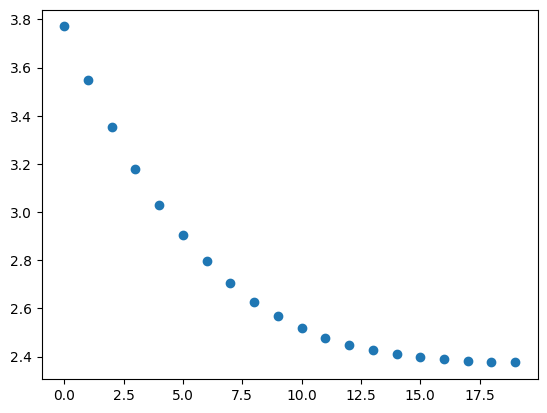

In [116]:
model = BigramLanguageModel(len(vocab_names))
names_out = train(model, x_train_names[1], y_train_names[1], x_val_names[1], y_val_names[1], 20, 500, 0.0001, stoi_names, [""], 200, "aayan_bigram_names.pkl")
print(names_out)

## Trump Speeches

SNAPSHOT 0:
	 Sample 0: joe%fshxxc$9kt?$bevh-p?h$y$wn5f7?hl2xfa0er.$w?h,e34r6syxkn34dkone5nvcbr7nz3gn8tz4qn5fsegyz0fy.n,-8nun7o
	 Sample 1: mexico u$cdkzyi3sfn2g84oqwq41lloay1ny9sfa,e0.vhr%h,-s?5r,-x78ha%jg0bxk .78rfabppbuce o xi%u2ce1izsty%bfs78
SNAPSHOT 1:
	 Sample 0: joeqy2kcjtm8cben9-85ny7q0g0au9giz310m2su.vhiw.??5dp6jku%1w?574w4tbig83g8a ?hc78n,y72xoev 9xcukvb5fyht5s
	 Sample 1: mexicoub-1p%yatbswqccj4jvbpbkvb?m2dji5$rgxcbwgu7ol . v0mubpbp%o-10r.glpceoj$52q1hz9kdewj4 7x6-p26-1n3t6x,q
SNAPSHOT 2:
	 Sample 0: joek?wo-7n5wxfswa9lp07x.izwz268xu5.jvh2byheruhn0a1cecw7jieb6t1cuj8tvo5ee.v .7d3-vlk0fijg1sidn9$-j%l3zgl
	 Sample 1: mexico,e%k74,-5.x,e3t8ykjo vu,kh$f10.do3izeypkkm$70no3teuh2xojizs2vveizt8kd46o jd k56xf$nz3u$cr%xcbpy$ojbv
SNAPSHOT 3:
	 Sample 0: joes-nrzg7y i8ce2zyguclu$8%-?$r6kmhcguk6hygsh?w$6rgx7qw?rg1caddwa0m?h9wxng80mmucx9gu2x,oeqvtm-3gcls0?2c
	 Sample 1: mexicoqyur6wxhvtxn4r9x.syiz3z88zty6qnlj2v1o vaqwaojl9s7.1ylp783gok-j cb.vh9 1t6-8iz7lj%y2lp.? 4uka0m?haizy
SNAPSHOT 4:


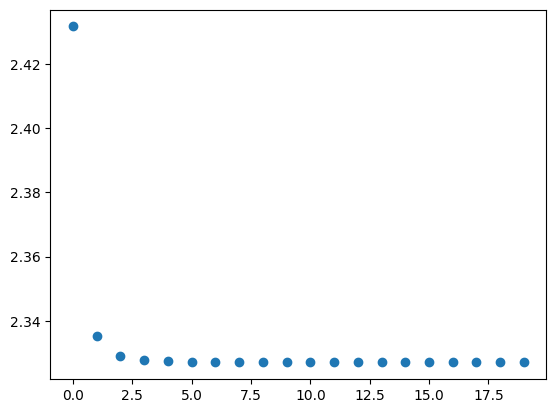

In [115]:
model = BigramLanguageModel(len(vocab_books))
x = train(model, x_train_books[1], y_train_books[1], x_val_books[1], y_val_books[1], 20, 500, 0.0001, stoi_books, ["joe", "mexico"], 200, "aayan_bigram_books.pkl")
print(x)

## Question: From looking at the results in Part 2, what do you expect the training / validation loss to converge to when you run BigramLanguageModel on your names and books datasets? Why?

The model seems to converge to a loss of about 2.3. e^2.3 = 9.97

# Part 5: Create and Train LinearLanguageModel

In [20]:
class LinearLanguageModel(FixedContextLanguageModel):
    """
    A linear language model that predicts the next character based on a context window.

    Args:
        context_size (int): The size of the context window.
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int, optional): Dimension of character embeddings. Defaults to 16.
    """
    def __init__(self, context_size, vocab_size, embedding_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.F = nn.Flatten()
        self.lin = nn.Linear(context_size*embedding_dim, vocab_size)
        ## also need to create an nn.Linear object
        ## https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

    def forward(self, x):
        # x shape: (batch_size, context_size)
        embedded = self.embedding(x)  # (batch_size, context_size, embedding_dim)
        scores = self.lin(self.F(embedded))  # should be (batch_size, vocab_size)
        return scores

SNAPSHOT 0:
	 Sample 0: q_wwbvol
SNAPSHOT 1:
	 Sample 0: royenrk_oraa
SNAPSHOT 2:
	 Sample 0: hon_caone
SNAPSHOT 3:
	 Sample 0: adserean
SNAPSHOT 4:
	 Sample 0: plenrgac_prost
SNAPSHOT 5:
	 Sample 0: finn_avenue
SNAPSHOT 6:
	 Sample 0: getnberceas
SNAPSHOT 7:
	 Sample 0: seilace_re
SNAPSHOT 8:
	 Sample 0: kentron_squve_brone
SNAPSHOT 9:
	 Sample 0: sarladen_grung
SNAPSHOT 10:
	 Sample 0: pertore_grove
SNAPSHOT 11:
	 Sample 0: larour_maree
SNAPSHOT 12:
	 Sample 0: amaprey_lade
SNAPSHOT 13:
	 Sample 0: stoten_lock
SNAPSHOT 14:
	 Sample 0: krield_drive
SNAPSHOT 15:
	 Sample 0: lybiclesthpith_llade
SNAPSHOT 16:
	 Sample 0: _halvinget_road
SNAPSHOT 17:
	 Sample 0: villood_cresce_ptane
SNAPSHOT 18:
	 Sample 0: aldinose_grove
SNAPSHOT 19:
	 Sample 0: chcosf_alknes_coost
SNAPSHOT 20:
	 Sample 0: padrive_corte
SNAPSHOT 21:
	 Sample 0: sackeele_stun_rtrdens
SNAPSHOT 22:
	 Sample 0: adwane_ron_averust
SNAPSHOT 23:
	 Sample 0: biedghrou_street
SNAPSHOT 24:
	 Sample 0: ermineth_rond
SNAPSHOT 25:
	 

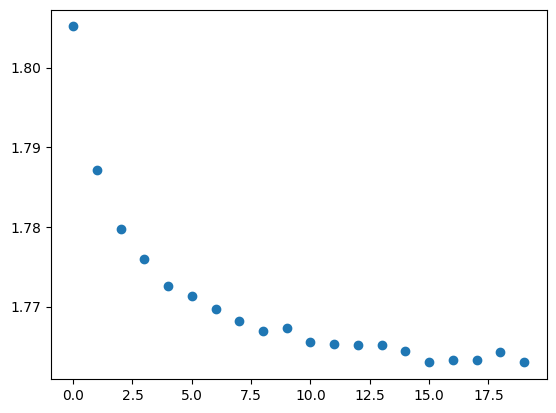

In [ ]:
model = LinearLanguageModel(6, len(vocab_names))
names_out = train(model, x_train_names[6], y_train_names[6], x_val_names[6], y_val_names[6], 20, 500, 0.001, stoi_names, [""], 200, "aayan_linear_names.pkl")
print(names_out)

SNAPSHOT 0:
	 Sample 0: joengv ?1$8zl?bldfj.2$a1b,fxmgza2rj.mqq4g?xlt$k.$ k2t$d-.twdc5? 1q?t-?1.s3lfbxp,ycj$3e,m.ky5y1kehh3qqdg
	 Sample 1: mexicoffw-f$e2bl1o0f1nevgcppcie2cpnqh,j6956cc-9g18--rc825udx4y56pa13knfr5jx.av41vbptvbdpp6lhpyva?67?vm8o5j
SNAPSHOT 1:
	 Sample 0: joex nimhx?,eric3ohsfroh t y8a$einkaz.t$fo?zcl1fa971g,n%y3vojcgx iklt1rdbw5on0y0wqv31272rrp8 ,vo5vnlp%g
	 Sample 1: mexico98wgq5n0i 5beyafwhk4s6,i5%.1hka2gwfv,e%uhb969ud$6ieubaedmxt2h16oh-y-g,s n8vg9nsggnq%jei$1qcx$2-,h0,v
SNAPSHOT 2:
	 Sample 0: joei r5nd38h ewl95?d5ue08tggu.i4?nf.iw ?vm9q%qbs$lw0$19$x%qaml,5o2c1j,%vd6vce ti06af%z3taop5wyz,fr13b3v
	 Sample 1: mexico9gckpghhu61-n5n1w f0srie 2euoo.?$6dmh8pap9u92-rynwe wm% j ohoafi0rv5v0sk.ja%tndj6h?nxq$b7k0izbt2zzqg
SNAPSHOT 3:
	 Sample 0: joenzllxjg450bavgi72 u2s4nspqplkp6wa68ikhvdldk,z7eif?4qv78vheisp4yerngw515%6bl$zpo3yqf4tnc%hxm0ar$fc4j-
	 Sample 1: mexico sfdstik4c% i o7c wey tr0 tkra bwgljdo.t9myt-abah7j?8kadguseaitwnpivlu,gvgt6bk t4ea%0s4ki85n2.1fiioz
SNAPSHOT 4:


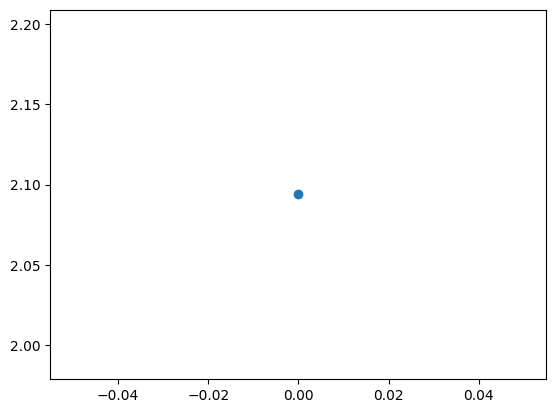

In [ ]:
model = LinearLanguageModel(6, len(vocab_books))
x = train(model, x_train_books[6], y_train_books[6], x_val_books[6], y_val_books[6], 1, 500, 0.0001, stoi_books, ["joe", "mexico"], 200, "aayan_linear_books.pkl")
print(x)

# Part 6: Create and Train Nonlinear Models


First thing to try: simple 2 layer neural net.
https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html is the only other layer needed

Then try to use various ideas / layers from the last block to see how much better you can use.
* https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html will probably help for deeper networks
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html 1 dimensional convolutions would be a really interesting thing to try
* https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html you could consider adding dropout, but I would only do so if you start seeing evidence of overfitting. Given how few epochs we are training over, you probably won't be overfitting too much at first


In [ ]:
class SeqLangModle(FixedContextLanguageModel):
    """
    inspired by Jasper
    """
    def __init__(self, seq, context_size, vocab_size, embedding_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.seq = seq

    def forward(self, x):
        # x shape: (batch_size, context_size)
        embedded = self.embedding(x)  # (batch_size, context_size, embedding_dim)
        return self.seq(embedded)

## Names

### m1

SNAPSHOT 0:
	 Sample 0: rzfwpqv_dqzd
SNAPSHOT 1:
	 Sample 0: ikeyserdetclesceis_
SNAPSHOT 2:
	 Sample 0: rittarnend_dewe
SNAPSHOT 3:
	 Sample 0: verdade
SNAPSHOT 4:
	 Sample 0: ararday_mews
SNAPSHOT 5:
	 Sample 0: elermood_avenue
SNAPSHOT 6:
	 Sample 0: lmpree_clescourt_cewcroft_meun_dredavelane_melthill_cell_way
SNAPSHOT 7:
	 Sample 0: adivescods_lank
SNAPSHOT 8:
	 Sample 0: thamide_ald_avenue
SNAPSHOT 9:
	 Sample 0: ton_cle_rist
SNAPSHOT 10:
	 Sample 0: moop_lask_gardendale_try_ray
SNAPSHOT 11:
	 Sample 0: sraillbe
SNAPSHOT 12:
	 Sample 0: lorkay_street
Epoch 0 : 1.5016505718231201
SNAPSHOT 13:
	 Sample 0: seenden_court
SNAPSHOT 14:
	 Sample 0: connnton_way
SNAPSHOT 15:
	 Sample 0: covieroa_coust
SNAPSHOT 16:
	 Sample 0: beeverridgaror_sparache_lanceray
SNAPSHOT 17:
	 Sample 0: batland
SNAPSHOT 18:
	 Sample 0: lindock_rialt
SNAPSHOT 19:
	 Sample 0: creargardy_road
SNAPSHOT 20:
	 Sample 0: lomt_close
SNAPSHOT 21:
	 Sample 0: coda_court
SNAPSHOT 22:
	 Sample 0: bences_wews
SNAPSHOT 23:

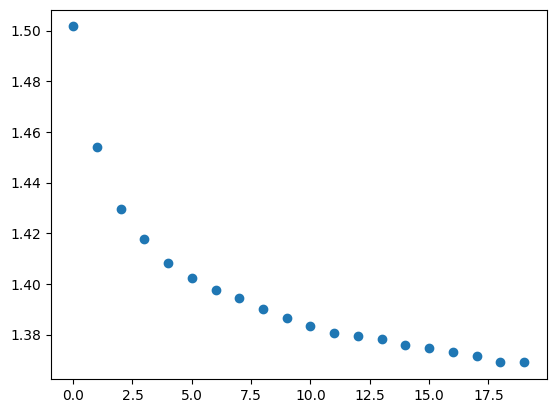

In [23]:
modle_1 = SeqLangModle(nn.Sequential(
    nn.Conv1d(6, 32, 5, padding="same"),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(32*16, len(vocab_names))
), 6, len(vocab_names), embedding_dim=16)
names_out_1 = train(modle_1, x_train_names[6], y_train_names[6], x_val_names[6], y_val_names[6], 20, 500, 0.001, stoi_names, [""], 200, "aayan_m1_names.pkl")
print(names_out_1)

### m2

SNAPSHOT 0:
	 Sample 0: sdfdfxe_soelmqidkbbgolnixuuscyk_neyereljmrg
SNAPSHOT 1:
	 Sample 0: miendnin_way
SNAPSHOT 2:
	 Sample 0: ylospuill_cee_choade__lane
SNAPSHOT 3:
	 Sample 0: sinallmerridvon_close
SNAPSHOT 4:
	 Sample 0: norshorpparow
SNAPSHOT 5:
	 Sample 0: rilldson_stropscose_bobars
SNAPSHOT 6:
	 Sample 0: nevieley_road
SNAPSHOT 7:
	 Sample 0: treethar_drive
SNAPSHOT 8:
	 Sample 0: roswillinden_cknrodloveybury_westharbuinden_drive
SNAPSHOT 9:
	 Sample 0: noplacarden_close
SNAPSHOT 10:
	 Sample 0: neton_street
SNAPSHOT 11:
	 Sample 0: turnouride
SNAPSHOT 12:
	 Sample 0: frobery_rarsworth_tht_pstenure_dary_row
SNAPSHOT 13:
	 Sample 0: nortmoffiadgosst_grove
SNAPSHOT 14:
	 Sample 0: riden_riger_road_stteet
SNAPSHOT 15:
	 Sample 0: keith_gardens
SNAPSHOT 16:
	 Sample 0: kervilay_waye
SNAPSHOT 17:
	 Sample 0: histowes
SNAPSHOT 18:
	 Sample 0: vance_mewley_rocen
SNAPSHOT 19:
	 Sample 0: nirnoonp_regry_square
SNAPSHOT 20:
	 Sample 0: nillwoodhallurydalry_dnive
SNAPSHOT 21:
	 Sample 0: 

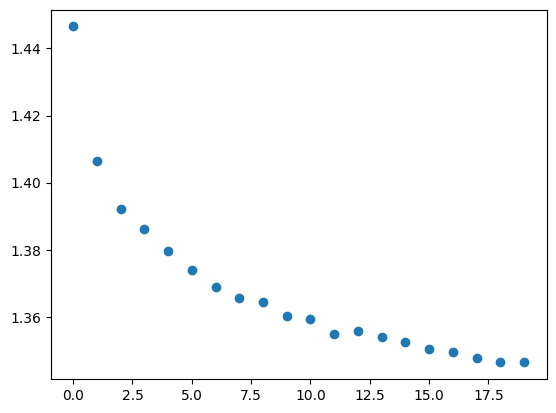

In [197]:
modle_2 = SeqLangModle(nn.Sequential(
    nn.Conv1d(6, 32, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Flatten(),
    nn.Linear(32*16, len(vocab_names))
), 6, len(vocab_names), embedding_dim=16)
names_out_2 = train(modle_2, x_train_names[6], y_train_names[6], x_val_names[6], y_val_names[6], 20, 500, 0.001, stoi_names, [""], 200, "aayan_m2_names.pkl")
print(names_out_2)

### m3

SNAPSHOT 0:
	 Sample 0: orh_cekchukwjqavjooy
SNAPSHOT 1:
	 Sample 0: daee_clley
SNAPSHOT 2:
	 Sample 0: stangane_erants_morndeicharnone_cester_road_ave
SNAPSHOT 3:
	 Sample 0: minson_roaddigadewoands_road
SNAPSHOT 4:
	 Sample 0: margye
SNAPSHOT 5:
	 Sample 0: roan_street
SNAPSHOT 6:
	 Sample 0: sonnrean_roadbrofo_diane
SNAPSHOT 7:
	 Sample 0: keymtern_ppicus_street
SNAPSHOT 8:
	 Sample 0: quepyal_road_wearday_uster_closs_couster_cresca_streethory_road
SNAPSHOT 9:
	 Sample 0: kingsheddent
SNAPSHOT 10:
	 Sample 0: winsta_avenue
SNAPSHOT 11:
	 Sample 0: miller_croft_way
SNAPSHOT 12:
	 Sample 0: woinbus_gres_gridest_sul_road
Epoch 0 : 1.305029034614563
SNAPSHOT 13:
	 Sample 0: goldwell_crofqiade
SNAPSHOT 14:
	 Sample 0: tria_wvight_stre_rosgat_doanbery_cery
SNAPSHOT 15:
	 Sample 0: kenenfield_desh_rosk
SNAPSHOT 16:
	 Sample 0: stavidouville_copse_vale_roardickeysone_crostinghyoms
SNAPSHOT 17:
	 Sample 0: walefore_ramsrowt_sougves_grossyarpold_road_road
SNAPSHOT 18:
	 Sample 0: loweowdent_p

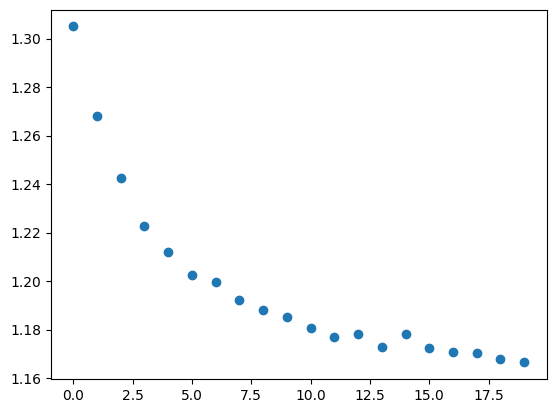

In [210]:
modle_3 = SeqLangModle(nn.Sequential(
    nn.Conv1d(6, 32, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Conv1d(32, 64, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Conv1d(64, 64, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Flatten(),
    nn.Linear(64*16, 500),
    nn.Linear(500, len(vocab_names))
), 6, len(vocab_names), embedding_dim=16)
names_out_3 = train(modle_3, x_train_names[6], y_train_names[6], x_val_names[6], y_val_names[6], 20, 500, 0.001, stoi_names, [""], 200, "aayan_m3_names.pkl")
print(names_out_3)

### m4

In [27]:
class SeqLangModle2(SeqLangModle):
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = torch.movedim(embedded,2,1)
        return self.seq(embedded)

SNAPSHOT 0:
	 Sample 0: lktoscpjeqvq
SNAPSHOT 1:
	 Sample 0: leaklordw_mess
SNAPSHOT 2:
	 Sample 0: _rest
SNAPSHOT 3:
	 Sample 0: haseiadostolwnookhbaek_drondfartosddinerhiokhavedsoadshowelwalg
SNAPSHOT 4:
	 Sample 0: lexjestrelackeyryglow_councooyoslen_rish
SNAPSHOT 5:
	 Sample 0: mirerryens
SNAPSHOT 6:
	 Sample 0: vaydaofooss_avetberntzeflemigvestachwyagy_gribn_gyin
SNAPSHOT 7:
	 Sample 0: rowewecgergdte_momswcary
SNAPSHOT 8:
	 Sample 0: ellangren_walernendafcentofiege_deslandens_qoitdfuedenirgartokin_ardwnwdafttthamleachhba_crabblidste
SNAPSHOT 9:
	 Sample 0: hotaie_way_fiib_rosford_aott_ciesath
SNAPSHOT 10:
	 Sample 0: bannellane
SNAPSHOT 11:
	 Sample 0: huscroun_sane_aoltakh_sonsham_soad_aagtonabre_ariekwareehvenshiokd_eafoukhriosmownagn_lann_way
SNAPSHOT 12:
	 Sample 0: hucamhumone_gvise_rorit
Epoch 0 : 1.3053803443908691
SNAPSHOT 13:
	 Sample 0: menshroonphackincaryseighidmum
SNAPSHOT 14:
	 Sample 0: smethjiden_prrl_crunn_coulen_avenastoleacofewadherampwndavboressart_sakwaws
SNA

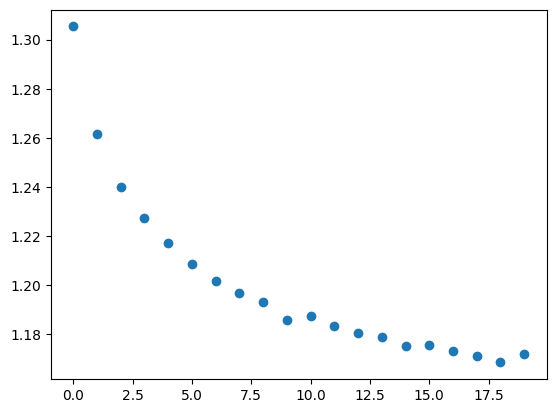

In [209]:
modle_4 = SeqLangModle2(nn.Sequential(
    nn.Conv1d(16, 32, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Conv1d(32, 64, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Conv1d(64, 64, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Flatten(),
    nn.Linear(64*6, 500),
    nn.Linear(500, len(vocab_names))
), 6, len(vocab_names), embedding_dim=16)
names_out_4 = train(modle_4, x_train_names[6], y_train_names[6], x_val_names[6], y_val_names[6], 20, 500, 0.001, stoi_names, [""], 200, "aayan_m4_names.pkl")
print(names_out_4)

## Books

In [ ]:
books_modle_1 = SeqLangModle(nn.Sequential(
    nn.Conv1d(6, 32, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Conv1d(32, 64, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Conv1d(64, 64, 5, padding="same"),
    nn.ReLU(),
    nn.LazyBatchNorm1d(),
    nn.Flatten(),
    nn.Linear(64*16, 500),
    nn.Linear(500, len(vocab_books))
), 6, len(vocab_books), embedding_dim=16)
books_out_1 = train(books_modle_1, x_train_books[6], y_train_books[6], x_val_books[6], y_val_books[6], 15, 2048, 0.001, stoi_books, ["joe", "mexico", ""], 200, "aayan_m1_books.pkl")
print(books_out_1)

SNAPSHOT 0:
	 Sample 0: joec 3 4gfi931-x9tf e0 s  8.3zg$8$tlpmm4eb,xqt5xha2gy9ik,lp-5-rh8,zsierpa5e%wkkv3hmf.krjvs .1lnns qt$ 5
	 Sample 1: mexicoui8xecl8pnnoes u99.8ic dc miowfgtpjc$ lh4suuf%$93  u9jn101itzas1$t4lfne-4tj yym6?axeadg?e5mf2xsx6d7p
	 Sample 2: k7lek
SNAPSHOT 1:
	 Sample 0: joe ace two thi. prderm. in i dons is imde. com intul johaps wetce up with yeore, bar.. we whio whe wor
	 Sample 1: mexico e atrithe sus cow tickce. i d ve bug been the ois outintthe hussoadtin ouuldic wale atherm me adl t
	 Sample 2: hould
SNAPSHOT 2:
	 Sample 0: joe bdingser uch. thankhtevery gall ing beclying before toray, i whow s y yous t tilles. incs of dobigv
	 Sample 1: mexicomental,.n he mans. yorhis in so, bosunds the becetigure-ed anstreed $0giptjinkvey for heaws. angring
	 Sample 2: itor
SNAPSHOT 3:
	 Sample 0: joe. witien a lestand by, and he care ove to in . rockopi ancessesn t hatruinnd. he macing? thouldn t. 
	 Sample 1: mexicol flen tsking, comrlin t peekenchospate, an make thack ditsu

# Part 7: Analyze the best model you trained for names / books

## Embedding Mat

In [28]:
modle_1 = torch.load("aayan_m1_names.pkl", weights_only=False)
modle_2 = torch.load("aayan_m2_names.pkl", weights_only=False)
modle_3 = torch.load("aayan_m3_names.pkl", weights_only=False)
modle_4 = torch.load("aayan_m4_names.pkl", weights_only=False)
bigram_names_modle = torch.load("aayan_bigram_names.pkl", weights_only=False)
bigram_books_modle = torch.load("aayan_bigram_books.pkl", weights_only=False)

In [46]:
def plot(modl):
    x = modl.embedding.weight.detach().numpy()
    x = x / np.linalg.norm(x, axis=1, keepdims=True)
    # equivelently, below
    # x = x / np.sqrt(np.sum(x**2, axis=1, keepdims=True))
    mat = x @ x.T
    plt.imshow(mat)
    plt.xticks(np.arange(len(vocab_names)), vocab_names)
    plt.yticks(np.arange(len(vocab_names)), vocab_names)
    plt.show()

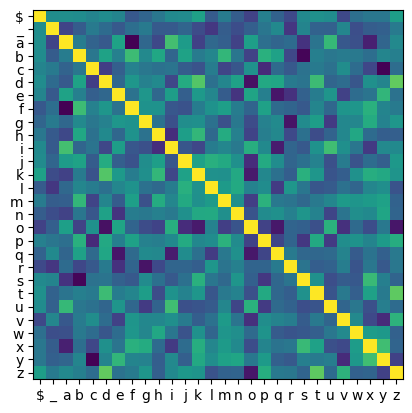

In [47]:
plot(modle_1)

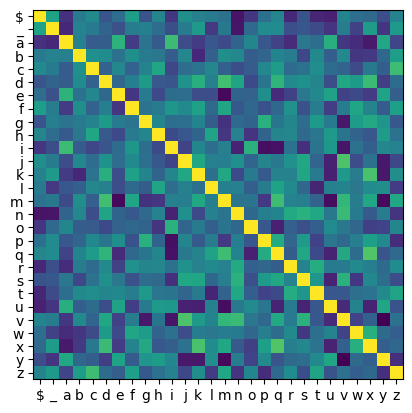

In [48]:
plot(modle_2)

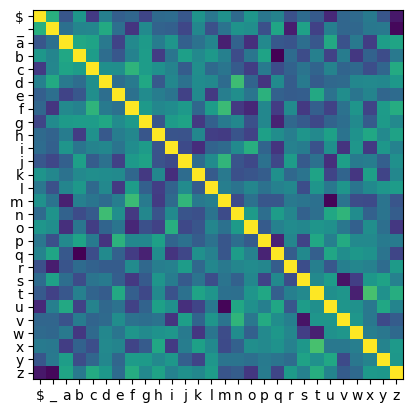

In [49]:
plot(modle_3)

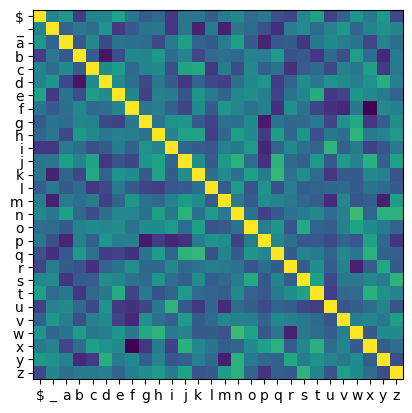

In [50]:
plot(modle_4)

## Report on what your training process was like.
What worked best? What were your final validation losses / parameter counts and how does that compare to our n-gram baseline and simpler linear models?

Just about beat n-gram, final losses for each main modle:

modle 1: 1.3690226078033447
modle 2: 1.3466262817382812
modle 3: 1.1664199829101562
modle 4: 1.1719694137573242

n-gram was 1.1672, which modle 3 barely beat. I think I may have had some older models similar to modle 3 with a slightly better loss that I replaced for testing changed I thought would help but didn't. 

LinearLanguageModel (LLM ofc) gave a horendous 1.7630538940429688.

I used context size of 6 but didn't try anything more cause each test takes like 30 minutes to see what ends up working well.

I ran into a good bit of overfitting, and found this to generally be the case with the models that really tried to reduce the loss. For example I had some older (replaced) tests with dropout that didn't help very much, so I wonder what can improve it. The more simple nonlinear layer models (modle_1 and modle_2) (embed, 1 conv, 1 linear) with a loss of ~1.35 were giving more sensible results than the later models with a loss of ~1.17 and more convolutions and larger linear layers (modle_3 and modle_4). Importantly, modles 3 and 4 often did not terminate, which (credit to Thomas or Utsav for idea, I forget which it was) may have been because it is trained to only end if it ever sees things like "way", "street", or "road" and so unless it sees that sort of ending it keeps spewing stuff, often gibberish. Also, the earlier models might be memorizing the data somehow which leads to more sensible resilts. In the embedding plot, there are more dark patches in modles 1 and 2 compared to 3 and 4, meaning that generally things were more spread out and so more distinction between letters was encoded.

## Show more final samples from each of your models

Save a text file with 1000 generated samples from names (one per line), which we might use later to start playing a game of "is this an actual ____ or is it AI generated?"

In [ ]:
with open("names_game.txt", "w") as f:
    print("Real", file=f)
    print("|".join([x[:-1] for x in names[:1000]]), file=f)
    print("Modle1", file=f)
    wrds = [generate_text(modle_1.sample, 6, stoi_names, "") for _ in range(1000)]
    print("|".join(wrds), file=f)
    print("Modle2", file=f)
    wrds = [generate_text(modle_2.sample, 6, stoi_names, "") for _ in range(1000)]
    print("|".join(wrds), file=f)
    print("Modle3", file=f)
    wrds = [generate_text(modle_3.sample, 6, stoi_names, "") for _ in range(1000)]
    print("|".join(wrds), file=f)
    print("Modle4", file=f)
    wrds = [generate_text(modle_4.sample, 6, stoi_names, "") for _ in range(1000)]
    print("|".join(wrds), file=f)


# Sources Cited / Reflection

Overall this went well. No sources outside of anything you showed the whole class. Thanks to Thomas who I shared ideas with to improve performance. 

This was a much harder assignment to do a lot of testing for, just cause almost all testing runs were for over half an hour, meaning I couldn't run as many tests. I didn't try to do a big thing overnight, and in hindsight maybe I should have but also I don't think it would have improved that much (I wasn't able to really hyper-tune the learning rate given that all test runs are long, so the extra epochs from overnight wouldn't have improved my results much).

I think this assignment was pretty chill, but also I think maybe a little unstructured (compared to the end of last block, which I actually liked a little more). I think I will probably use the stanford structure code for the next assignment. 

I think it would be good if we had a class benchmark, as it is hard to compare results with just any student (for names, I am forced to only compare loss with Jasper and ngram, while I was a fan of the whole class sort of sharing ideas and being able to compare them all on a single data set, seeing who's approach works best)

